In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display, HTML
from opik import Opik, track
from opik.integrations.langchain import OpikTracer

os.environ["OPIK_PROJECT_NAME"] = "capstone-playground-assessment-agent"

load_dotenv()

print(os.environ['TAVILY_API_KEY'][:20])
print(os.environ['OPENAI_API_KEY'][:20])
print(os.getenv("OPIK_WORKSPACE"))
print(os.getenv("OPIK_PROJECT_NAME"))

tvly-dev-V8aZJqKSeyA
sk-proj-oSYhDCExsLks
divya-venkatraman
capstone-playground-assessment-agent


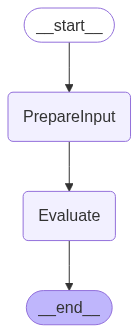

In [30]:
# Define your model
model = ChatOpenAI(model="gpt-4o")

# Define State for LangGraph
# Extended state
class AssessmentState(TypedDict, total=False):
    requirement: str
    evidence: str
    input_prompt: list  # list of BaseMessage
    judgment: str

# Step 1: Prepare prompt
def prepare_input(state: AssessmentState):
    template = ChatPromptTemplate.from_messages([
        HumanMessagePromptTemplate.from_template(
                "You are an AI compliance assessor. You will be given a governance requirement and structured evidence.\n"
                "Your task is to assess whether the evidence:\n"
                "1. Completely meets the requirement\n"
                "2. Partially meets the requirement\n"
                "3. Does not meet the requirement\n\n"
                "Provide a final judgment using one of the three labels and explain your reasoning with specific points from the evidence.\n\n"
                "Governance Requirement:\n{requirement}\n\n"
                "Evidence:\n{evidence}"
            )
    ])
    prompt_value = template.invoke({
        "requirement": state["requirement"],
        "evidence": state["evidence"]
    })
    return {"input_prompt": prompt_value.to_messages()}

# Step 2: Evaluate
def evaluate_with_llm(state: AssessmentState):
    response = model.invoke(state["input_prompt"])
    return {"judgment": response.content}

# Build the LangGraph
workflow = StateGraph(AssessmentState)
workflow.add_node("PrepareInput", prepare_input)
workflow.add_node("Evaluate", evaluate_with_llm)
workflow.set_entry_point("PrepareInput")
workflow.add_edge("PrepareInput", "Evaluate")
workflow.add_edge("Evaluate", END)

graph = workflow.compile()
tracer = OpikTracer(graph=graph.get_graph(xray=True))
display(Image(graph.get_graph().draw_mermaid_png()))


In [31]:
# Run the agent with your example input
ai_rmf = pd.read_excel('nist_ai_rmf_playbook_structured.xlsx',sheet_name="Sheet1")
ai_rmf.head()
requirement_text = ai_rmf[ai_rmf["section_id"]=='GOVERN 1.6']['section_about'].values[0]
# #"""An AI system inventory is an organized database of artifacts relating to an AI system or model... (full text omitted here for brevity)"""
print(requirement_text)
evidence_df = pd.read_csv("Simulated_AI_System_Inventory.csv")
evidence_text = evidence_df.to_string(index=False)
print(evidence_text)


An AI system inventory is an organized database of artifacts relating to an AI system or model. It may include system documentation, incident response plans, data dictionaries, links to implementation software or source code, names and contact information for relevant AI actors, or other information that may be helpful for model or system maintenance and incident response purposes. AI system inventories also enable a holistic view of organizational AI assets. A serviceable AI system inventory may allow for the quick resolution of:

- specific queries for single models, such as  “when was this model last refreshed?” 
- high-level queries across all models, such as, “how many models are currently deployed within our organization?” or “how many users are impacted by our models?” 

AI system inventories are a common element of traditional model risk management approaches and can provide technical, business and risk management benefits. Typically inventories capture all organizational model

In [ ]:
# If only the requirement description is sent
result = graph.invoke({
    "requirement": requirement_text,
    "evidence": evidence_text
})

print("Judgment:\n", result["judgment"])

Judgment:
 Final Judgment: Completely meets the requirement

Reasoning:

1. **Comprehensive Coverage**: The evidence provides a detailed inventory covering multiple AI systems and models, including a diverse range of model types (e.g., classification, anomaly detection, regression, rule-based NLP, clustering). This aligns with the requirement for an organized database of artifacts.

2. **Detailed Artifacts**: Each model entry contains detailed information, such as:
   - **Model/System Name** and **Model Type**: This helps in identifying and classifying the model.
   - **Deployment Status** and **Environment**: Indicates whether a model is deployed or in development, and its deployment environment, meeting the need for tracking system status.
   - **Business and Technical Owner, Points of Contact**: Human resource management aspect is present, enabling maintenance and incident response by identifying responsible individuals.
   - **Dates** (e.g., Date of Last Refresh, Initial Deployment

In [34]:
# If only the requirement description along with documentation is sent
control_ID = 'GOVERN 1.6'
requirement_text_withdoc = ai_rmf[ai_rmf["section_id"]==control_ID]['section_about'].values[0] + " " + ai_rmf[ai_rmf["section_id"]==control_ID]['section_doc'].values[0]

result = graph.invoke({
    "requirement": requirement_text_withdoc,
    "evidence": evidence_text
})

print("Judgment:\n", result["judgment"])

Judgment:
 Based on the evidence provided, the assessment of compliance with the governance requirement for maintaining an AI system inventory is as follows:

1. **Completeness of the Inventory**:
   - The evidence lists multiple models with structured details, which include essential components like Model/System Name, Deployment Status, Business Owner, Technical Owner, Date of Last Refresh, and Initial Deployment Date, among others. This suggests a thorough inventory capturing substantial information on individual AI systems within the organization.

2. **Contents of Inventory**:
   - The inventory includes system documentation, incident response plans, data dictionaries, links to documentation and source code, and contact points which align with the requirement's definition of a comprehensive AI system inventory.
   - Other crucial aspects like Training Data Source(s), Security Controls Applied, and Model Evaluation Metrics are also captured.

3. **Holistic View and Query Resolution*

In [36]:
requirement_text = ai_rmf[ai_rmf["section_id"]=='GOVERN 1.6']['section_about'].values[0]
print(requirement_text)
evidence__incomplete_df = pd.read_csv("Simulated_AI_System_Inventory_incomplete.csv")
evidence_text = evidence__incomplete_df.to_string(index=False)
print(evidence_text)

result = graph.invoke({
    "requirement": requirement_text_withdoc,
    "evidence": evidence_text
})

print("Judgment:\n", result["judgment"])

An AI system inventory is an organized database of artifacts relating to an AI system or model. It may include system documentation, incident response plans, data dictionaries, links to implementation software or source code, names and contact information for relevant AI actors, or other information that may be helpful for model or system maintenance and incident response purposes. AI system inventories also enable a holistic view of organizational AI assets. A serviceable AI system inventory may allow for the quick resolution of:

- specific queries for single models, such as  “when was this model last refreshed?” 
- high-level queries across all models, such as, “how many models are currently deployed within our organization?” or “how many users are impacted by our models?” 

AI system inventories are a common element of traditional model risk management approaches and can provide technical, business and risk management benefits. Typically inventories capture all organizational model